In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")

react_graph = builder.compile()

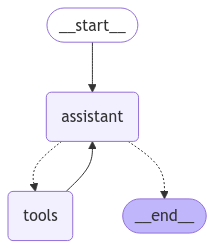

In [12]:
from IPython.display import Image, display

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_XtSw22gdkReH9MwWjMw5lEJE)
 Call ID: call_XtSw22gdkReH9MwWjMw5lEJE
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e3Et8HfIaFz7OGhkjEZJCyr1)
 Call ID: call_e3Et8HfIaFz7OGhkjEZJCyr1
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_7DHMboYyLy8xCq2L0lHomNCd)
 Call ID: call_7DHMboYyLy8xCq2L0lHomNCd
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

In [15]:
messages = [HumanMessage(content="divide that by 2")]
messages = react_graph.invoke({"messages": messages})

In [16]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

divide that by 2
================================== Ai Message ==================================

Could you please specify the number you would like to divide by 2?


## Memory

In [19]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

react_graph_memory = builder.compile(checkpointer=memory)

In [20]:
config = {"configurable":{"thread_id": "1"}}

messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph_memory.invoke({"messages":messages}, config)

In [24]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_tfmGrrujJqJJ2hDk2RIL5Q29)
 Call ID: call_tfmGrrujJqJJ2hDk2RIL5Q29
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [25]:
messages = [HumanMessage(content="Multiply that by 2")]
messages = react_graph_memory.invoke({"messages":messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_tfmGrrujJqJJ2hDk2RIL5Q29)
 Call ID: call_tfmGrrujJqJJ2hDk2RIL5Q29
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_laHAqpTHdwGk8EjdVis5u5ng)
 Call ID: call_laHAqpTHdwGk8EjdVis5u5ng
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multiply